# Case3-challenge05-check

In this note, we check whether we can reproduce ra/dec values in the data from the parameters also written in the data.

At first, we add the analysis directory to the python path.

In [1]:
import sys
sys.path.append('/home/kamizuka/analysis')

At first, we load the data, 'case3_chalenge_05.txt'.

In [2]:
import astropy.io.ascii as asc
from astropy import units as u

data = asc.read('case3_challenge_05.txt')
data['x'] = data['x']*1.e-3 # Converting um to mm.
data['y'] = data['y']*1.e-3 # Converting um to mm.
data['x'].unit = u.mm
data['y'].unit = u.mm
data['ra'].unit = u.deg
data['dec'].unit = u.deg

The source distribution is shown in the figure below.

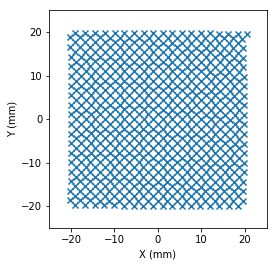

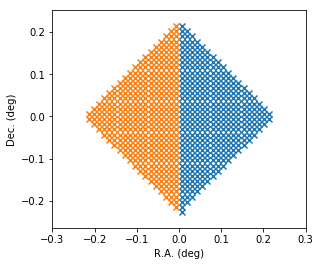

In [4]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['x'], data['y'], marker='x')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_xlim([-25,25])
ax.set_ylim([-25,25])
ax.set_aspect('equal', adjustable='box')

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='x')
ax.scatter(data['ra']-360.0, data['dec'], marker='x')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
ax.set_aspect('equal', adjustable='box')

We set the field parameters as below.

In [5]:
import warpfield as w
from astropy.coordinates import SkyCoord, Longitude, Latitude, Angle

ra_ptg  = 0.0*u.deg
dec_ptg = 0.0*u.deg
pa_ptg  = 134.8344427850505*u.deg

pointing = SkyCoord(Longitude(ra_ptg), Latitude(dec_ptg), frame='icrs')
jasmine  = w.Telescope(pointing, Angle(pa_ptg))
scale    = jasmine.optics.scale/3600. * 1000. * u.deg/u.mm

print(ra_ptg)
print(dec_ptg)
print(pa_ptg)
print(scale)

0.0 deg
0.0 deg
134.8344427850505 deg
0.007848736919600318 deg / mm


We set the distortion parameters as below.

In [6]:
import numpy as np

sip_c = np.zeros(shape=(5, 5))
sip_d = np.zeros(shape=(5, 5))

sip_c[0,2]=2.7904129220013768e-08
sip_c[1,1]=-5.80878134023515e-08
sip_c[1,2]=-5.2516980717814774e-12
sip_c[2,0]=-5.7138016575414155e-08
sip_c[2,1]=-9.240828377471048e-12
sip_c[2,2]=-2.6125490126936015e-15

sip_d[0,2]=-1.523875997615861e-07
sip_d[1,1]=-7.424068371191725e-08
sip_d[1,2]=-7.033438017074073e-12
sip_d[2,0]=-2.1396206560762395e-07
sip_d[2,1]=-6.2947496092425084e-12
sip_d[2,2]=5.977204669126082e-16

print(sip_c)
print(sip_d)

[[ 0.00000000e+00  0.00000000e+00  2.79041292e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -5.80878134e-08 -5.25169807e-12  0.00000000e+00
   0.00000000e+00]
 [-5.71380166e-08 -9.24082838e-12 -2.61254901e-15  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00 -1.52387600e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -7.42406837e-08 -7.03343802e-12  0.00000000e+00
   0.00000000e+00]
 [-2.13962066e-07 -6.29474961e-12  5.97720467e-16  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


Here, we define a function to construct a wcs instance from given parameters.

In [7]:
from astropy.wcs import WCS
from astropy.wcs import Sip

def wcs(ra0, dec0, pa0, scale0, a=None, b=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale0, scale0])
    w.wcs.crval=[ra0, dec0]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa0*u.deg), np.sin(pa0*u.deg)],
              [-np.sin(pa0*u.deg), np.cos(pa0*u.deg)]]
    if a is not None and b is not None:
        w.sip = Sip(a, b, None, None, [0, 0])
    return w

And we define a model function which calculates RA and Dec from the position on the focal plane with considering the distortion. It is represented by the Sip function implemented to astropy.wcs.

In [8]:
def model(params, pxcrd, sip_order):
    # params must be an ndarray of dimension-less values.
    # assuming params = [ra, dec, pa, scale, a00, a01, ..., a0m, a10, a11, ..., amm, b00, b01, ..., bmm].
    ra_ptg  = params[0] # value in deg.
    dec_ptg = params[1] # value in deg.
    pa_ptg  = params[2] # value in deg.
    scale   = params[3] # value in deg/mm.
    a = params[4:4+(sip_order+1)**2].reshape((sip_order+1, sip_order+1))
    b = params[4+(sip_order+1)**2:4+2*(sip_order+1)**2].reshape((sip_order+1, sip_order+1))
#    # constraining some parametes to be zero.
#    m, n = np.indices((sip_order+1, sip_order+1))
#    pos = np.where((m+n==0)+(m+n==1)+(m+n>sip_order))
#    a[pos] = 0.
#    b[pos] = 0.
#    # additional constraints.
#    pos = (np.array([0, 0, 1, 3, 3, 4]), np.array([3, 4, 3, 0, 1, 0]))
#    a[pos] = 0.
#    b[pos] = 0.
    
    w = wcs(ra_ptg, dec_ptg, pa_ptg, scale, a, b)
    world = w.all_pix2world(pixcrd, 0)

    # constraining ra and dec in 'world' between -180 to 180 deg.
    pos = np.where(world>180.)
    world[pos] = world[pos] - 360.
    pos = np.where(world<-180.)
    world[pos] = world[pos] + 360.
    
    return world.T.flatten()

Then, we make an array of the coordinates on the focal plane.

In [9]:
pixcrd = np.concatenate(([data['x']],[data['y']])).T

Let's compare the ra/dec values calculated from the derived parameters with the true values.

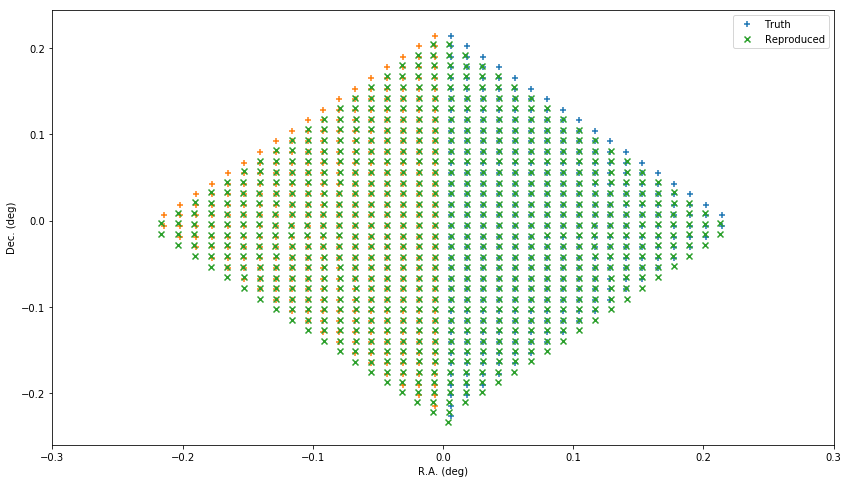

In [11]:
params    = np.concatenate(([ra_ptg.value, dec_ptg.value, pa_ptg.value, scale.value], sip_c.flatten(), sip_d.flatten()))
positions = model(params, pixcrd, 4)
positions = positions.reshape((2,int(positions.size/2))).T

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='+', label='Truth')
ax.scatter(data['ra']-360., data['dec'], marker='+', label='')
ax.scatter(positions[:,0], positions[:,1], marker='x', label='Reproduced')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
#ax.set_aspect('equal', adjustable='box')
ax.legend()

The reproduced ra/dec values show offset from the true values. Why...?